In [1]:
import os
import json
import pandas as pd
import numpy as np
import json

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, LogFormatterExponent, ScalarFormatter
import seaborn as sb

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
sb.set_style("darkgrid")
sb.set_context("paper",  font_scale = 1,
               rc={
                   "grid.linewidth": 3.75,
                   'axes.labelsize': 28,
                   "axes.titlesize": 32,
                   "legend.fontsize": 28.0,
                   'lines.linewidth': 5,
                   'xtick.labelsize': 24.0,
                   'ytick.labelsize': 24.0,
               })
current_palette = list(sb.color_palette())
colors = {
    'RL': current_palette[0],
    'RR': current_palette[5],
    'SOP':current_palette[4],
    'RAND':current_palette[7],
    'optimal':current_palette[1],
    '0':current_palette[-2],
    '1':current_palette[-1]
}

In [3]:
opt_cost_dict = {
     0: 22,  1: 56,  2: 56,  3: 60,  4: 22,  5:  54,  6: 27,  7: 12,  8: 14,  9: 120,
    10: 42, 11: 35, 12: 28, 13: 32, 14: 24, 15:  15, 16: 24, 17: 45, 18: 90, 19:  60,
    20: 10, 21: 40, 22: 28, 23: 54, 24: 72, 25: 108, 26: 14, 27: 80, 28: 60, 29:  20
}

exp_dir = '/home/biedenka/git/rl-plan'

opt_pols = {}
for inst in range(30):
    with open(os.path.join(exp_dir, 'artifical-benchmarks', 'train', 'instance%d' % inst, 'optimal.json')) as fh:
        opt_pol = json.load(fh)[1:]
#     print('Instance %d' % inst)
#     print(opt_pol)
#     print(inst, len(opt_pol))
#     print()
    opt_pols[inst] = opt_pol
    opt_cost_dict[inst] = len(opt_pol)


data_dir = "/home/biedenka/git/rl-plan/experiments/baseline_data/"
static_cost = {}
random_cost = {}
round_robin_cost = {}
rl_cost = {}

static_traj = {}
random_traj = {}
round_robin_traj = {}
rl_traj = {}

print('Loading Data')
for instance in range(30):
    with open(os.path.join(data_dir, 'train', 'instance-%d-random.json' % instance), 'r') as fh:
        data = json.load(fh)
        random_cost[instance] = (data['mean'], data['stdev'])
        random_traj[instance] = data['trajectories']

#     with open(os.path.join(data_dir, 'train', 'instance-%d-rl-25-wide.json' % instance), 'r') as fh:
#         data = json.load(fh)
#         rl_cost[instance] = (data['mean'], data['stdev'])
#         rl_traj[instance] = data['trajectories']
    
    for act in [0, 1]:
        if act not in static_cost:
            static_cost[act] = {}
            static_traj[act] = {}
            round_robin_cost[act] = {}
            round_robin_traj[act] = {}
        with open(os.path.join(data_dir, 'train', 'instance-%d-static-action-%d.json' % (instance, act)), 'r') as fh:
            data = json.load(fh)
            static_cost[act][instance] = (data['mean'], data['stdev'])
            static_traj[act][instance] = data['trajectories']
            
        for switch in range(1, 25):
            if switch not in round_robin_cost[act]:
                round_robin_cost[act][switch] = {}
                round_robin_traj[act][switch] = {}
            with open(os.path.join(data_dir, 'train', 'instance-%d-rr-%d-act%d.json' % (instance, switch, act)), 'r') as fh:
                data = json.load(fh)
                round_robin_cost[act][switch][instance] = (data['mean'], data['stdev'])
                round_robin_traj[act][switch][instance] = data['trajectories']

static_cost['oracle_portfolio'] = {}
static_traj['oracle_portfolio'] = {}
for i in range(len(opt_cost_dict.keys())):
    better_act = 0 if static_cost[0][i] > static_cost[1][i] else 1
    static_cost['oracle_portfolio'][i] = static_cost[better_act][i]
    static_traj['oracle_portfolio'][i] = static_traj[better_act][i]
print('Done')

Loading Data
Done


In [4]:
def plot(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2]):
    for units in uni:
        for layers in lay:

            fig = plt.figure(figsize=(15, 5), dpi=50)
            ax = plt.gca()
            for exploration in exp:
                
                exp_dir = os.path.join(
                    os.path.sep, 'mhome', 'biedenka',
                    'rl-plan-tmp', 'experiments', 'toy-benchmarks',
                    'old_feats_wide_long_full_train_set_%d-%d-%d' % (
                                           layers, units, exploration))
                if exploration == 1:
                    print('#'*80)
                    print(exp_dir)
                    print('#'*80)
                try:
                    df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                     index_col=None)
                except Exception as e:
                    print(e)

                if not plot_bsf:
                    plt.step(df.steps, df['mean'] * -1, where='mid', label='mean',
                             alpha=0.25)
                    plt.xlabel('#steps')
                else:
                    mean = df['mean']
                    mead = df['median']
                    me, md = [], []
                    for idx, v in enumerate(zip(mean, mead)):
                        if idx == 0: 
                            me.append(v[0])
                            md.append(v[1])
                            continue
                        if v[0] > me[-1]:
                            me.append(mean[idx])
                            md.append(mead[idx])
                        else:
                            me.append(me[-1])
                            md.append(md[-1])
                    # additional +1 as reward is misaligned by 1
                    data = (np.array(me) +1) * -1
                    plt.step(df.steps, (np.array(me) +1) * -1, where='post')
                    print('Final RL', data[-1])
                    #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                    #           label='median-bsf')

            ax.set_ylabel('RL-Cost')
            if plot_bsf:
                ax.set_title('Individual Incumbent Performances on Training Set')
                opt_mean = np.mean(list(opt_cost_dict.values()))
                static_0 = -np.mean(list(static_cost[0].values()))
                static_1 = -np.mean(list(static_cost[1].values()))
                static_o = -np.mean(list(static_cost['oracle_portfolio'].values()))
                random_mean = np.mean(
                    [-x[0] for x in random_cost.values()])
                random_std  = np.std([x[1] for x in random_cost.values()])
                ssteps = [0, 1_000_000]
                plt.plot(ssteps, [opt_mean, opt_mean],
                         ls='--', label='optimal',
                         color=colors['optimal'])
                ssteps[0] = 0  # np.sum(list(static_cost[0].values()))/1000
                plt.plot(ssteps, [static_0, static_0],
                         ls='--', # label='1-mean',
                         label='0',
                         color=colors['0'])
                ssteps[0] = 0  # np.sum(list(static_cost[1].values()))/1000
                plt.plot(ssteps, [static_1, static_1],
                         ls='--', # label='1-mean',
                         label='1',
                         color=colors['1'])
                ssteps[0] = 0
                plt.plot(ssteps, [static_o, static_o],
                         ls='--', label='SOP',
                         color=colors['SOP'])
                plt.plot(ssteps, [random_mean, random_mean],
                         ls='--', label='RAND',
                         color=colors['RAND'])
                plt.fill_between(ssteps, random_mean + random_std,
                                 random_mean - random_std, alpha=0.25,
                                 color=colors['RAND'])

                for act in [0]:  # [0, 1]:
                    for switch in [11]:  # [3,4,5,6,7]:
                        v = np.mean([
                            -x[0] for x in round_robin_cost[act][switch].values()])
                        plt.plot(ssteps, [v, v],
#                                  label = 'rr-%d-%d' % (act, switch),
                                 label = 'RR',
                                 ls = '--',
                                 color=colors['RR'])
                plt.ylim([0, 600])
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                          fancybox=True, shadow=True, ncol=4)
                plt.xlabel('#steps')
                plt.xlim([0, 1_000_000])
            else:
                ax.set_title('Individual Performances on Training Set')
                plt.ylim([0, 1_500])
                plt.xlim([0, 1_000_000])
                plt.xlabel('#steps')
            ax.get_xaxis().set_major_formatter(
            FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.savefig('toy_res_{:s}_layer_{:d}_units_{:d}_state_2.pdf'.format(
            'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
            plt.savefig('toy_res_{:s}_layer_{:d}_units_{:d}_state_2.png'.format(
            'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
            plt.show()
            print()
            print()

In [5]:
def plot_means(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2],
               quantile=False):
    for units in uni:
        for layers in lay:

            fig = plt.figure(figsize=(15, 5), dpi=50)
            ax = plt.gca()
            dfs = []
            for exploration in exp:
                
                exp_dir = os.path.join(
                    os.path.sep, 'mhome', 'biedenka', 'rl-plan-tmp',
                    'experiments', 'toy-benchmarks',
                    'old_feats_wide_long_full_train_set_%d-%d-%d' % (
                        layers, units, exploration))
                if exploration == 1:
                    print('#'*80)
                    print(exp_dir)
                    print('#'*80)
                try:
                    df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                     index_col=None)
                    dfs.append(df)
                except Exception as e:
                    print(e)

            if not plot_bsf:
                frame = pd.concat(dfs)
                if quantile:
                    df = frame.groupby(frame.index).quantile(q=.5)
                    dsu = frame.groupby(frame.index).quantile(q=.75)
                    dsl = frame.groupby(frame.index).quantile(q=.25)
                    u = dsl['mean'] * -1
                    l = dsu['mean'] * -1
                    um = dsl['median'] * -1
                    lm = dsu['median'] * -1
                else:
                    df = frame.groupby(frame.index).mean()
                    ds = frame.groupby(frame.index).std()
                    u = df['mean'] * -1 + ds['mean']
                    l = df['mean'] * -1 - ds['mean']
                    um = df['median'] * -1 + ds['median']
                    lm = df['median'] * -1 - ds['median']
                plt.step(df.steps, df['mean'] * -1, where='post',
                         label='mean', color='blue')
                plt.fill_between(df.steps, u, l, step='post', color='b', alpha=0.25)
#                 plt.step(df.steps, df['median'] * -1, where='post',
#                          label='median', color='orange')
#                 plt.fill_between(df.steps, um, lm, step='post',
#                                  color='orange', alpha=0.25)
                plt.xlabel('#steps')
            else:
                mes = []
                stps = []
                ml = -1
                for df in dfs:
                    mean = df['mean']
                    mead = df['median']
                    steps = df['steps']
                    me, md = [], []
                    stp = []
                    for idx, v in enumerate(zip(mean, mead, steps)):
                        if idx == 0: 
                            me.append(v[0])
                            md.append(v[1])
                            stp.append(v[2])
                            continue
                        if v[0] > me[-1]:
                            me.append(mean[idx])
                            md.append(mead[idx])
                            stp.append(steps[idx])
                        else:
                            me.append(me[-1])
                            md.append(md[-1])
                            stp.append(steps[idx])
                    if len(me) > ml:
                        ml = len(me)
                    mes.append(me)
                    stps.append(stp)
                for idx in range(len(mes)):
                    while len(mes[idx]) < ml:
                        mes[idx].append(np.nan)
                        stps[idx].append(np.nan)
                
                if quantile:
                    m = -np.nanquantile(mes, q=.5, axis=0)
                    u = -np.nanquantile(mes, q=.25, axis=0)
                    l = -np.nanquantile(mes, q=.75, axis=0)
                else:
                    m = -np.nanmean(mes, axis=0)
                    u = m + np.nanstd(mes, axis=0)
                    l = m - np.nanstd(mes, axis=0)
                stps = np.nanmean(stps, axis=0)
                plt.step(stps, m, where='post',
                         label='RL',
                         color=colors['RL'])

                plt.fill_between(stps, u, l, step='post', alpha=0.25,
                         color=colors['RL'])
                print('Final RL', m[-1])
                #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                #           label='median-bsf')

            ax.set_ylabel('RL-Cost')
            if plot_bsf:
                ax.set_title('Incumbent Performance on Training Set')
                opt_mean = np.mean(list(opt_cost_dict.values()))
                static_0 = -np.mean(list(static_cost[0].values()))
                static_1 = -np.mean(list(static_cost[1].values()))
                static_o = -np.mean(list(static_cost['oracle_portfolio'].values()))
                random_mean = np.mean([
                    -x[0] for x in random_cost.values()])
                random_std = np.std([x[1] for x in random_cost.values()])
                ssteps = [0, 1_000_000]
                plt.plot(ssteps, [opt_mean, opt_mean],
                         ls='--', label='optimal',
                         color=colors['optimal'])
                ssteps[0] = 0  # np.sum(list(static_cost[0].values()))/1000
                plt.plot(ssteps, [static_0, static_0],
                         ls='--', label='0',
                         color=colors['0'])
                ssteps[0] = 0  # np.sum(list(static_cost[1].values()))/1000
                plt.plot(ssteps, [static_1, static_1],
                         ls='--', label='1',
                         color=colors['1'])
                ssteps[0] = 0
                plt.plot(ssteps, [static_o, static_o],
                         ls='--', label='SOP',
                         color=colors['SOP'])
                plt.plot(ssteps, [random_mean, random_mean],
                         ls='--', label='RAND',
                         color=colors['RAND'])
                plt.fill_between(ssteps, random_mean + random_std,
                                 random_mean - random_std, alpha=0.25,
                                 color=colors['RAND'])

                for act in [0]:  # [0, 1]:
                    for switch in [11]:  # [3,4,5,6,7]:
                        v = np.mean([
                            -x[0] for x in round_robin_cost[act][switch].values()])
                        plt.plot(ssteps, [v, v],
#                                  label = 'rr-%d-%d' % (act, switch),
                                 label = 'RR',
                                 ls = '--',
                                 color=colors['RR'])
                plt.ylim([0, 600])
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                          fancybox=True, shadow=True, ncol=4)
                plt.xlabel('#steps')
                plt.xlim([0, 1_000_000])
#                 plt.xlim([1, 1_000_000])
#                 plt.semilogx()
            else:
                ax.set_title('Performance on Training Set')
                plt.ylim([0, 1_000])
                plt.xlim([0, 1_000_000])
                plt.xlabel('#steps')
            ax.get_xaxis().set_major_formatter(
            FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.savefig(
                'toy_res_mean_over_10_runs_{:s}_layer_{:d}_'\
                'units_{:d}_state_2.pdf'.format(
            'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
            plt.savefig(
                'toy_res_mean_over_10_runs_{:s}_layer_{:d}_'\
                'units_{:d}_state_2.png'.format(
            'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
            plt.show()
            print()
            print()

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
# Results over 10 seeds

#### Plot Incumbent Performance

##### Plots using mean +- stdev
plot_means(plot_bsf=True, old=True, lay=[2], uni=[75, 150, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=False)
           
           
           
##### Plots using Quartiles:           

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-75-1
################################################################################
Final RL 44.16666666666666


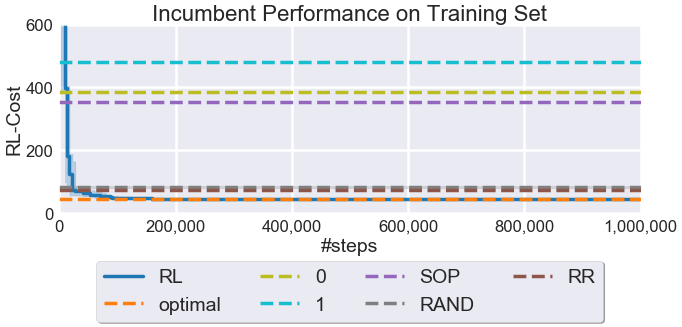



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-200-1
################################################################################
Final RL 44.13333333333333


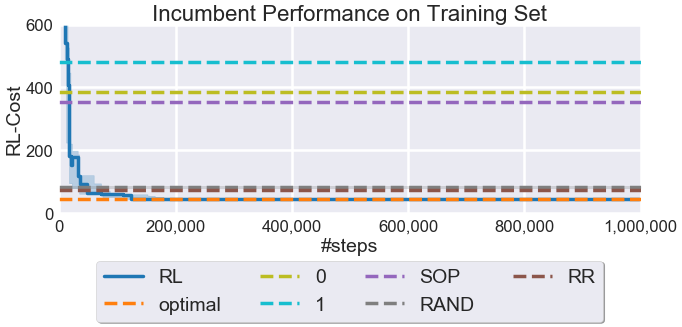

In [6]:
plot_means(plot_bsf=True, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True)

#### Plot RL Performance

##### Plots using mean +- stdev
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75, 150, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=False)
           
           
           
##### Plots using Quartiles:           

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-75-1
################################################################################


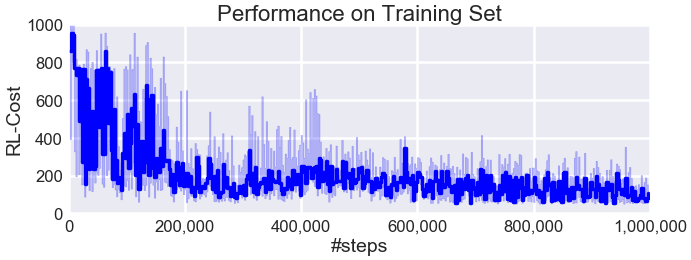



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-200-1
################################################################################


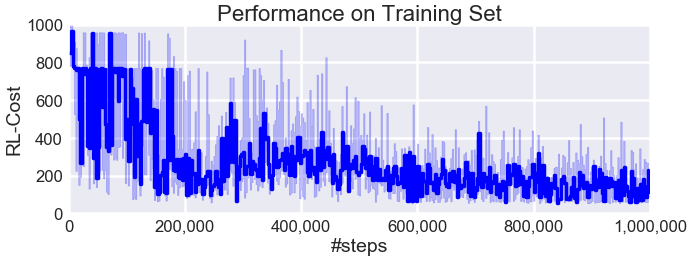

In [7]:
##### Plots using Quartiles
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True)

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
## Plotting individual runs
<BR>

#### OLD FEATS
##### Very Wide Nets

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-75-1
################################################################################
Final RL 43.16666666666666
Final RL 44.16666666666666
Final RL 44.2
Final RL 43.13333333333333
Final RL 43.3
Final RL 43.16666666666666
Final RL 43.66666666666666
Final RL 43.13333333333333
Final RL 43.13333333333333
Final RL 43.13333333333333


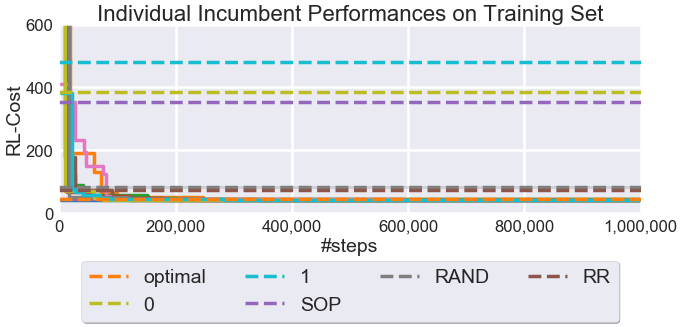



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-200-1
################################################################################
Final RL 84.53333333333333
Final RL 43.13333333333333
Final RL 43.13333333333333
Final RL 43.36666666666667
Final RL 43.13333333333333
Final RL 43.13333333333333
Final RL 43.13333333333333
Final RL 43.13333333333333
Final RL 45.0
Final RL 43.2


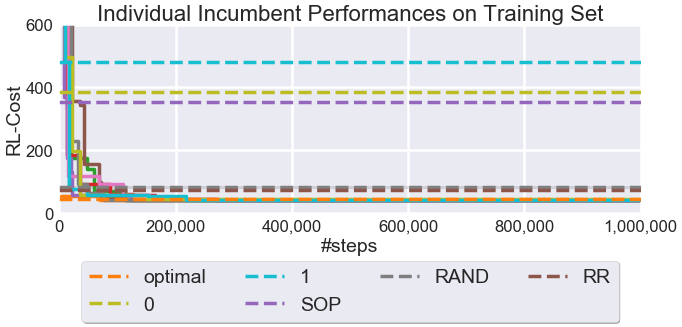

In [8]:
plot(old=True, lay=[2], uni=[75, 200],
     exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-75-1
################################################################################


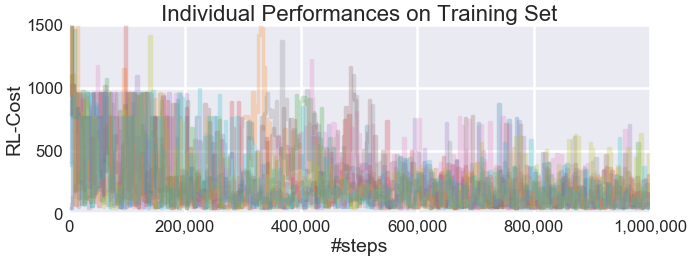



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/toy-benchmarks/old_feats_wide_long_full_train_set_2-200-1
################################################################################


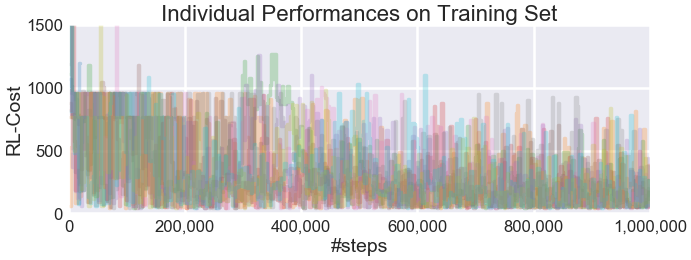

In [9]:
plot(plot_bsf=False, old=True, lay=[2], uni=[75, 200],
     exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
## Determining the best RR schedule

In [10]:
# round_robin_cost -> action -> switch -> instance

best = -np.inf
best_a = -1
best_switch = -1
for action in [0, 1]:
    for switching_point in range(1, 25):
        inst_data = []
        inst_data_std = []
        for inst_ID in range(30):
            inst_data.append(round_robin_cost[action][switching_point][inst_ID][0])
        mean = np.mean(inst_data)
        if mean > best:
            best = mean
            best_a = action
            best_switch = switching_point
        print(action, switching_point, mean)
print('#'*80)
print('Best RR: action-%d switch-%d' % (best_a, best_switch))

0 1 -80.0
0 2 -81.26666666666667
0 3 -79.46666666666667
0 4 -81.03333333333333
0 5 -79.36666666666666
0 6 -77.1
0 7 -78.5
0 8 -78.46666666666667
0 9 -76.1
0 10 -75.26666666666667
0 11 -74.6
0 12 -75.8
0 13 -75.63333333333334
0 14 -79.76666666666667
0 15 -80.43333333333334
0 16 -82.16666666666667
0 17 -82.33333333333333
0 18 -82.33333333333333
0 19 -79.03333333333333
0 20 -80.86666666666666
0 21 -83.9
0 22 -86.33333333333333
0 23 -86.33333333333333
0 24 -89.33333333333333
1 1 -80.13333333333334
1 2 -81.53333333333333
1 3 -79.83333333333333
1 4 -81.53333333333333
1 5 -79.96666666666667
1 6 -77.83333333333333
1 7 -79.26666666666667
1 8 -78.76666666666667
1 9 -77.06666666666666
1 10 -76.86666666666666
1 11 -75.86666666666666
1 12 -77.06666666666666
1 13 -76.53333333333333
1 14 -80.0
1 15 -80.06666666666666
1 16 -83.86666666666666
1 17 -84.3
1 18 -84.6
1 19 -82.56666666666666
1 20 -83.56666666666666
1 21 -86.56666666666666
1 22 -87.5
1 23 -87.66666666666667
1 24 -90.4
######################